In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg as sclinalg, interpolate

**1.1**

In [2]:
def newtonian_kernel_matrix(target_points, source_points):
    target_tiled = np.tile(np.expand_dims(target_points, 1), (1, len(source_points), 1))
    source_tiled = np.tile(np.expand_dims(source_points, 0), (len(target_points), 1, 1))
    return 1/np.sqrt(np.sum(np.square(target_tiled - source_tiled), axis=-1))


def random_points_in_cube(xlims, ylims, zlims, n_points):
    x_vals = np.random.uniform(*xlims, n_points)
    y_vals = np.random.uniform(*ylims, n_points)
    z_vals = np.random.uniform(*zlims, n_points)
    return np.stack([x_vals, y_vals, z_vals], axis=-1)

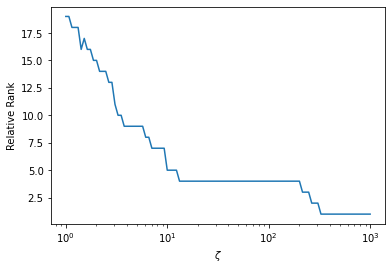

In [6]:
zeta_vals = np.logspace(0,3, 100)
N = 20
M = 20
eps = 1e-6
target_points = random_points_in_cube((0, 1), (0, 1), (0, 1), 20)
ranks = []
for zeta in zeta_vals:
  source_points = random_points_in_cube((zeta, zeta + 1), (0, 1), (0, 1), 20)
  kernel_mat = newtonian_kernel_matrix(target_points, source_points)
  _, vals, _ = sclinalg.svd(kernel_mat)
  max_val = np.max(vals)
  rel_rank = np.sum(np.where(vals > eps * max_val, np.ones_like(vals), np.zeros_like(vals)))
  ranks.append(rel_rank)

fig, axs = plt.subplots()
axs.plot(zeta_vals, ranks)
axs.set_xlabel(r"$\zeta$")
axs.set_ylabel(r"Relative Rank")
axs.set_xscale("log")

The relative rank decreases, eventually all the way to 1, as $\zeta$ is increased. This makes sense, as a collection points at $\zeta = 1000$ are pretty much indistinguishable from a single point, whcih would have rank 1.

Text(0, 0.5, 'Relative Rank')

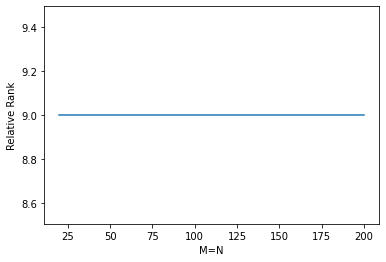

In [9]:
zeta = 6
all_n_points = np.arange(start=20, stop=210, step=10)
ranks = []
for n_points in all_n_points:
  target_points = random_points_in_cube((0, 1), (0, 1), (0, 1), n_points)
  source_points = random_points_in_cube((zeta, zeta + 1), (0, 1), (0, 1), n_points)
  kernel_mat = newtonian_kernel_matrix(target_points, source_points)
  _, vals, _ = sclinalg.svd(kernel_mat)
  max_val = np.max(vals)
  rel_rank = np.sum(np.where(vals > eps * max_val, np.ones_like(vals), np.zeros_like(vals)))
  ranks.append(rel_rank)

fig, axs = plt.subplots()
axs.plot(all_n_points, ranks)
axs.set_xlabel("M=N")
axs.set_ylabel("Relative Rank")


At $\zeta = 6$, varying the number of sources doesn't really affect the rank. This makes sense, as the targets shouldn't really be able to perceive the increased detail at this distance. I did notice that if you make $\zeta$ smaller (say 1), the rank tends to increase linearly with the number of points, which makes sense.

**1.2**

In [10]:
def helmholtz_kernel_matrix(target_points, source_points, k):
    target_tiled = np.tile(np.expand_dims(target_points, 1), (1, len(source_points), 1))
    source_tiled = np.tile(np.expand_dims(source_points, 0), (len(target_points), 1, 1))
    abs_x = np.sqrt(np.sum(np.square(target_tiled - source_tiled), axis=-1))
    return np.exp(1j * k * abs_x)/abs_x


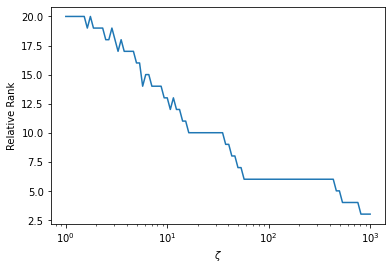

In [31]:
zeta_vals = np.logspace(0,3, 100)
N = 20
M = 20
eps = 1e-6
k=10
target_points = random_points_in_cube((0, 1), (0, 1), (0, 1), 20)
ranks = []
for zeta in zeta_vals:
  source_points = random_points_in_cube((zeta, zeta + 1), (0, 1), (0, 1), 20)
  kernel_mat = helmholtz_kernel_matrix(target_points, source_points, k)
  _, vals, _ = sclinalg.svd(kernel_mat)
  max_val = np.max(vals)
  rel_rank = np.sum(np.where(vals > eps * max_val, np.ones_like(vals), np.zeros_like(vals)))
  ranks.append(rel_rank)

fig, axs = plt.subplots()
axs.plot(zeta_vals, ranks)
axs.set_xlabel(r"$\zeta$")
axs.set_ylabel(r"Relative Rank")
axs.set_xscale("log")

Here I see pretty much the same thing as 1.1: the rank decreases as $\zeta$ is increased. In this case, we don't see the rank drop all the way down to 1, which is probably due to the finite wavenumber.

Text(0, 0.5, 'Relative Rank')

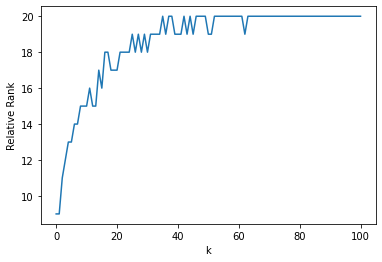

In [33]:
zeta = 6
N = 20
M = 20
all_wavenumbers = np.arange(start=0, stop=101, step=1)
ranks = []
for k in all_wavenumbers:
  target_points = random_points_in_cube((0, 1), (0, 1), (0, 1), M)
  source_points = random_points_in_cube((zeta, zeta + 1), (0, 1), (0, 1), N)
  kernel_mat = helmholtz_kernel_matrix(target_points, source_points, k)
  _, vals, _ = sclinalg.svd(kernel_mat)
  max_val = np.max(vals)
  rel_rank = np.sum(np.where(vals > eps * max_val, np.ones_like(vals), np.zeros_like(vals)))
  ranks.append(rel_rank)

fig, axs = plt.subplots()
axs.plot(all_wavenumbers, ranks)
axs.set_xlabel("k")
axs.set_ylabel("Relative Rank")

increasing the wavenumber seems to increase the rank of the system. This makes sense, as $1/k$ sets the effective length scale of the problem, so when we make $k$ larger we become more sensitive to the details of the positions of the sources and targets.

**2.1**

In [15]:
def poisson_kernel_matrix_2d(target_points, source_points):
    target_tiled = np.tile(np.expand_dims(target_points, 1), (1, len(source_points), 1))
    source_tiled = np.tile(np.expand_dims(source_points, 0), (len(target_points), 1, 1))
    return np.log(np.sqrt(np.sum(np.square(target_tiled - source_tiled), axis=-1)))


def random_points_in_square(xlims, ylims, n_points):
    x_vals = np.random.uniform(*xlims, n_points)
    y_vals = np.random.uniform(*ylims, n_points)
    return np.stack([x_vals, y_vals], axis=-1)

1.3661760917419262e-06


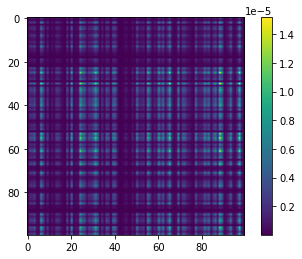

In [29]:
zeta = 6
N = 100
M = 100
vecs_to_keep = 4

target_points = random_points_in_square((0, 1), (0, 1), M)
source_points = random_points_in_square((zeta, zeta + 1), (0, 1), N)
kernel_matrix = poisson_kernel_matrix_2d(target_points, source_points)
U, vals, V = sclinalg.svd(kernel_matrix)
low_rank_approx = np.einsum("jk, k, ki -> ji", U[:, :vecs_to_keep], vals[:vecs_to_keep], V[:vecs_to_keep, :])
error = np.abs(low_rank_approx - kernel_matrix)/np.abs(kernel_matrix)

fig, axs = plt.subplots()
im = axs.imshow(error)
fig.colorbar(im, orientation='vertical')

print(np.mean(error))

This approximation is a bit silly, because in order to make it I first have to compute the entire kernel matrix, which has complexity O(MN). I then have to do an SVD, which has complexity like O(M^2 N) or O(N^2 M). So not great.

**2.2**

In [22]:
target_corners = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
corner_kernel_mat = poisson_kernel_matrix_2d(target_corners, source_points)
corner_potentials = np.sum(corner_kernel_mat, axis=1)
interpolator = interpolate.interp2d(target_corners[:, 0], target_corners[:, 1], corner_potentials)
interpolated_potentials = interpolator(target_points[:, 0], target_points[:, 1])
true_potentials = np.sum(kernel_matrix, axis=1)
error_interp = np.abs(interpolated_potentials - true_potentials)/np.abs(true_potentials)
print(np.mean(error_interp))

0.03023830618033969


Finding the potentials at the corners has complexity O(N). The interpolation process has complexity O(M). This method doesn't do very well in terms of error. That's probably because there's no physical basis for linear interpolation, other than the distances between points being small.

**2.3**

In [25]:
source_corners = np.array([[zeta, 0], [zeta, 1], [zeta + 1, 0], [zeta + 1, 1]])
corner_kernel_mat = poisson_kernel_matrix_2d(target_corners, source_corners)
point_masses = np.linalg.solve(corner_kernel_mat, corner_potentials)
target_kernel_mat = poisson_kernel_matrix_2d(target_points, source_corners)
colocated_potential = target_kernel_mat.dot(point_masses)
error_coloc = np.abs(colocated_potential - true_potentials)/np.abs(true_potentials)
print(np.mean(error_coloc))


4.0349564962168224e-07


Finding the true potentials at the target corners has complexity O(N). Computing the potential at the target points for the resulting point charges has complexity O(M). This method does very well in terms of error. This is not suprising, as we are essentially using physics to interpolate.

**2.4**

In [26]:
def compute_multipole_moment(x, mass_center, p):
  return np.sum((x - mass_center)**p)/p


def multipole_corrections(p_vals, multipole_moments, target_points_complex, source_mass_center):
  denom = np.exp(np.einsum("p, m -> mp", p_vals, np.log(target_points_complex - source_mass_center)))
  return np.einsum("p, mp -> m", multipole_moments, 1/denom)


In [27]:
source_mass_center = np.mean(source_points, axis=0)
mass_center_complex = source_mass_center[0] + 1j * source_mass_center[1]
source_points_complex = source_points[:, 0] + 1j * source_points[:, 1]
p_vals = [1, 2, 3, 4]
a_p = np.array([compute_multipole_moment(source_points_complex, mass_center_complex, p) for p in p_vals])
zeroth_order_potential = np.squeeze(poisson_kernel_matrix_2d(target_points, [source_mass_center]))
targets_complex = target_points[:, 0] + 1j * target_points[:, 1]
all_multipole_corr = multipole_corrections(p_vals, a_p, targets_complex, mass_center_complex)
multipole_pot = N * zeroth_order_potential - np.real(all_multipole_corr)
error_multi= np.abs(multipole_pot - true_potentials)/np.abs(true_potentials)
print(np.mean(error_multi))


3.086626338661356e-08


Computing the multipole coeffecients has complexity O(N). Computing the potential than has complexity O(M). This scheme seems to do a little better than the SVD, however both errors are so small that I wouldn't read into it much.